# Background

Em primeiro lugar, vamos observar o enunciado com atenção. Se seguida está um resumo das partes importantes dele.

## Contexto
> Pretende-se que seja implementada uma solução computacional para estudo e análise de dados de grande dimensão. Nesse sentido, deverá ser contruído um modelo de análise e processamento de dados baseado em métodos e algoritmos
lecionados nas aulas

> A escolha do domínio de dados e respetico conjunto de dados a utilizar, bem [como] a formulação do próprio problema em estudo, será da responsabilidade dos autores do trabalho, [... que ...] devem ser obtidos a partr da lista de fontes especificada [...] na tabela 1

Entre as opções, nós escolhemos a competição "Predict Student Performance from Game Play" pois parecia um tema com potencial, e parece alcançável com os métodos lecionados em aula, conforme o objetivo do projeto.

## Requesitos
> [...] requisito de utilização de Apache Spark e Python é mandatório
>
> [...] vão ser utilizados serviços em ambiente cloud, da Amazon para contexto académico – AWS Academy – na qual será disponibilizada uma classe de ensino para os(as) alunos(as) da unidade curricular
>
> Os algorimos a utilizar que estarão na base da construção do [... MAPD] devem fazer parte da plataforma Apache Spark
>
> A implementação da dolução deve ser [...] composta por mais do que um notebook ou módulo Python. Compete aos autores do trabalho a estruturar [...] o código implementado.
>
> A submissão consiste num arquivo em formato zip [...] com [...] (i) relatório e (ii) notebooks e/ou módulos Python.
>
> relatório deve ser um documento sucinto e em formato pdf, com o máximo de oito [8] páginas.
>
> O prazo de submissão é 12:00 de 8 de abril de 2023 [...].


Nesta secção, vamos observar os dados que temos de forma geral, e o objetivo da competição do kaggle.

Conforme o enuncuiado do kaggle:

> The goal of this competition is to predict student performance during game-based learning in real-time.

Nós temos acesso a uma base de dados de todos os eventos de cada sessão de um utilizador, e cada sessão tem 18 questões, onde nós sabemos se a sessão acertou em cada sessão. O nosso objetivo é prever, baseado nos movimentos e nas ações de uma sessão, se essa vai acertar ou errar nas questões. Vamos chamar a essas questões $q _\lambda, \lambda \in \left[ 1, 18 \right]$. O jogo parece apresentar 22 níveis, com 3 "checkpoints" de questões, um no nível 4, outro no nível 12 e o último no último nível, 22. Vamos chamar a esses níveis $n_\lambda, \lambda \in \left [1, 22\right]$. Para cada sessão $s$, temos que prever se $s$ vai acertar na questão, baseado nas ações prévias da sessão.

Para entender melhor a base de dados, nós planeamos fazer dois passos:

* Jogar o jogo.
* Interpretar os dados que nos dão.

## Jogar o jogar

O jogo encontra-se em https://pbswisconsineducation.org/jowilder/play-the-game/, e tem o título de **Jo Wilder and the Capitol Case**, produzido por *PBS Winsconsin Education*. 

O jogo simula uma investigadora mirim desvendando alguns misterios enquanto conhece a historia de sua cidade, percorrendo diversos locais na cidade é possivel explorar os edificios é elementos dentro dele, como livros, cartões é computadores.

TODO descrição melhor

## Interpretar os dados que nos dão

In [ ]:
import os
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"
import pyspark
from pyspark.sql import SparkSession
import pyspark.pandas as ps
from IPython import display

In [ ]:
spark = SparkSession.builder \
                    .master('local[1]') \
                    .appName('pbd') \
                    .getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)
! start http://localhost:4040/jobs/

Ao executar `kaggle c download -p .\data\predict-student-performance-from-game-play`, e exportar o zip resultado, são exportados 4 ficheiros csv: 
* test.csv - O ficheiro do conjunto de teste 
* train.csv - O ficheiro do conjunto de treino
* train_labels.csv - O ficheiro com as respostas das sessões
* sample_submission - O ficheiro com exemplos de resposta

TODO columns description

In [ ]:
paths = [r".\data\test.csv", r".\data\sample_submission.csv", r".\data\train_labels.csv", r".\data\train.csv"]
df_test, df_sample_submissions, df_train_labels, df_train = [
    spark.read.csv(r".\data\train.csv", inferSchema=False, header=True)
    for i in paths
]

In [ ]:
df_test.limit(10)

session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
20090312431273200,0,0,cutscene_click,basic,0,null,-413.99140522263224,-159.31468617022784,380.0,494.0,null,undefined,intro,tunic.historicals...,tunic.historicals...,0,0,1,0-4
20090312431273200,1,1323,person_click,basic,0,null,-413.99140522263224,-159.31468617022784,380.0,494.0,null,Whatcha doing ove...,gramps,tunic.historicals...,tunic.historicals...,0,0,1,0-4
20090312431273200,2,831,person_click,basic,0,null,-413.99140522263224,-159.31468617022784,380.0,494.0,null,Just talking to T...,gramps,tunic.historicals...,tunic.historicals...,0,0,1,0-4
20090312431273200,3,1147,person_click,basic,0,null,-413.99140522263224,-159.31468617022784,380.0,494.0,null,I gotta run to my...,gramps,tunic.historicals...,tunic.historicals...,0,0,1,0-4
20090312431273200,4,1863,person_click,basic,0,null,-412.99140522263224,-159.31468617022784,381.0,494.0,null,"Can I come, Gramps?",gramps,tunic.historicals...,tunic.historicals...,0,0,1,0-4
20090312431273200,5,3423,person_click,basic,0,null,-412.99140522263224,-157.31468617022784,381.0,492.0,null,"Sure thing, Jo. G...",gramps,tunic.historicals...,tunic.historicals...,0,0,1,0-4
20090312431273200,6,5197,person_click,basic,0,null,478.48507948953636,-199.9716787422361,593.0,485.0,null,"See you later, Te...",teddy,tunic.historicals...,tunic.historicals...,0,0,1,0-4
20090312431273200,7,6180,person_click,basic,0,null,503.35512792584535,-168.619912992023,609.0,453.0,null,I get to go to Gr...,teddy,tunic.historicals...,tunic.historicals...,0,0,1,0-4
20090312431273200,8,7014,person_click,basic,0,null,510.7334420194441,-157.72064191237214,615.0,442.0,null,Now where did I p...,teddy,tunic.historicals...,tunic.historicals...,0,0,1,0-4
20090312431273200,9,7946,person_click,basic,0,null,512.048004999717,-153.74363056897224,616.0,438.0,null,\u00f0\u0178\u02d...,teddy,tunic.historicals...,tunic.historicals...,0,0,1,0-4


Ao observar o output, podemos verificar que cada registo contém um evento de uma sessão, ordenada pelo seu `index` na sessão. Curiosamente, o `elapsed_time` não parece estar totalmente conforme o `index`, mas o `index` parece estar certo porque o `text` está conforme o `index`. Para verificar se este erro se mantém, vamos selecionar os primeiros `index` de cada sessão.

In [ ]:
(df_test
 .select("session_id", "index", "elapsed_time", "event_name")
 .filter("index < 5")
 .limit(20)
)

session_id,index,elapsed_time,event_name
20090312431273200,0,0,cutscene_click
20090312431273200,1,1323,person_click
20090312431273200,2,831,person_click
20090312431273200,3,1147,person_click
20090312431273200,4,1863,person_click
20090312433251036,0,0,cutscene_click
20090312433251036,1,218,person_click
20090312433251036,2,448,person_click
20090312433251036,3,702,person_click
20090312433251036,4,948,person_click


Baseado nestes resultados, não parece ser um problema. No entanto, para garantir persistência, parece uma boa ideia analisar isto mais a profundo, como por exemplo, pondo uma nova coluna que ira calcular a diferenca de tempo entre o último evento (inclusive calcular o tempo entre o último do mesmo evento).

Outra coisa que podemos reparar já é que as sessões e indexes parecem já ordenadas. Para podermos usar este facto temos que verificar que isto realmente acontece. Alternativamente, podemos garantir que este seja o facto independentemente se é o que se observa ou não, usando um `sort`. Esta alternativa parece mais fácil de implementar se necessário.

TODO resto das base de dados

## *Pipeline*

Esta secção será reservada para discutir a *pipeline* adequada para o nosso objetivo. A nossa ideia seria usar um processo iterativo adaptado do lecionado em aula 

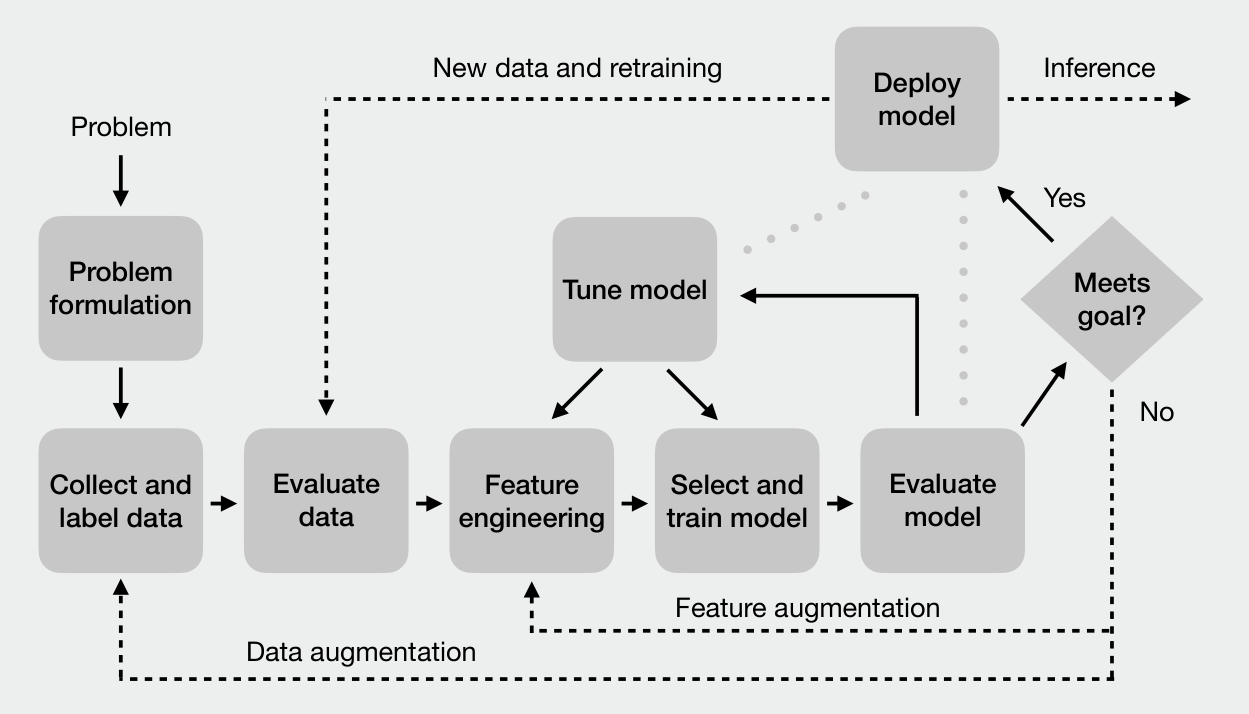
*Processo da aula*

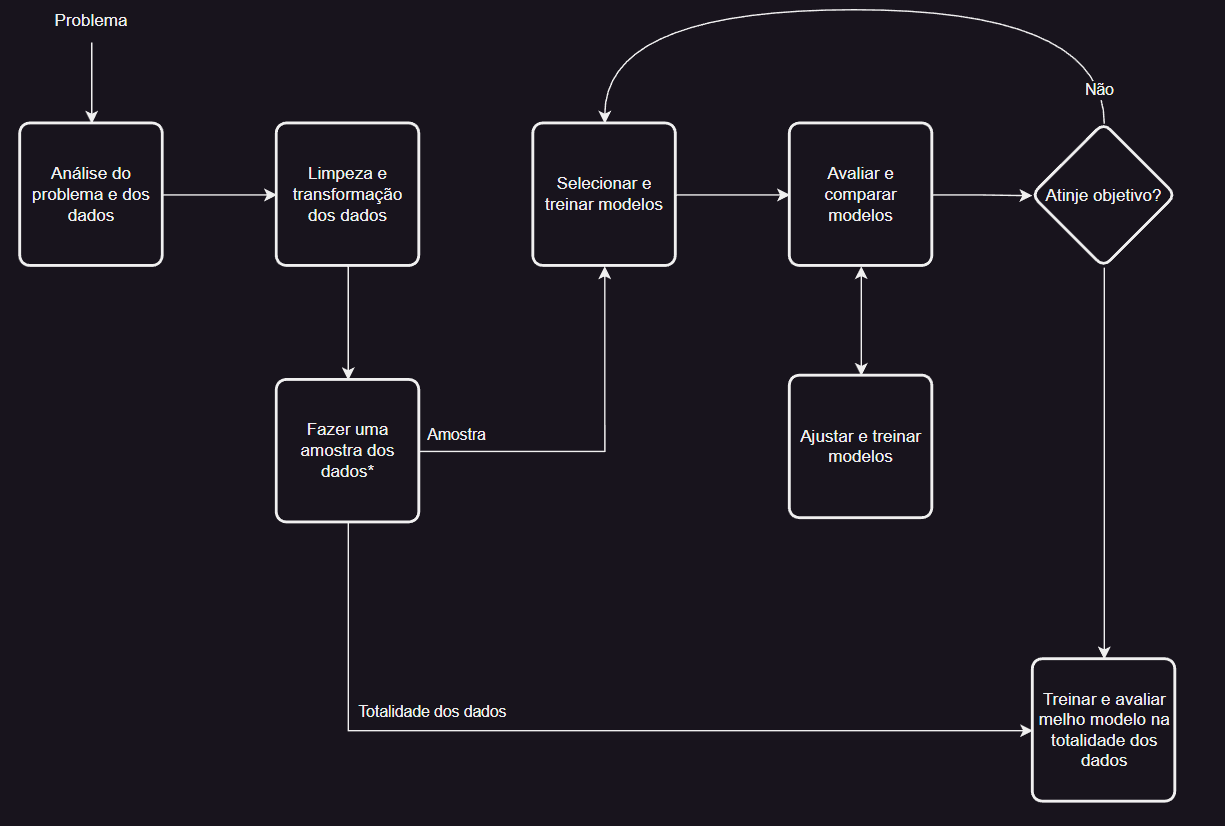
*processo adaptado*

*Por limitações computacionais, e no domínio deste projeto, planeamos em apenas usar uma amostra para avaliar e comparar modelos, e depois usar ferramentas como o AWS para terinar o modelo com a totalidade dos dados. Este processo pode ser adaptado, dependendo das propriedades base dos dados, especialmente do tamanho de tal.

Em termos de modelos, como este é um problema de classificação binária (respostas são ou 0 ou 1), podemos considerar modelos como regressão logística, Naive Bayes, K-Nearest Neighbours (knn), support-vector machine (SVM), entre outros. Teremos que noutro capítulo discutir quais escolher e comparar. Podemos potencialmente considerar também 

O que pode levantar questões já agora é como está formatado o objetivo. Sendo que será preciso prever 18 questões, a nossa primeira ideia será para o modelo prever um vetor (ou uma representação de tal) das 18 questões diretamente, tornando-se numa [previsão estruturada](https://en.wikipedia.org/wiki/Structured_prediction). Este formato pode dificultar a análise da previsão, sendo que o modelo estará essencialmente a prever 18 outputs, e temos que ter em atenção que as perguntas não são todas respondidas ao mesmo tempo. Alternativamente, podemos fazer um modelo que preveja cada questão separadamente; ou seja, efetivamente, 18 modelos (de caracteristicas semelhantes), treinados com a mesma base de dados, apenas com diferença na resposta que está a treinar. Isto iria diminuir a complexidade do problema, mas aumentaria o tempo e tamanho do projeto significativamente. Podemos também, em vez de 18 modelos, apenas dividir em 3 modelos, cada um para cada checkpoint; ou seja, 3 modelos para as questões da sua secção; isto parece ganhar os beneficios (e problemas) das duas opções apresentadas. Mais à frente, deve tornar-se mais obvio qual opção escolher.

Outro problema potencial imediato será de como formatar o nosso input, sendo que podemos ter uma grande quantidade de eventos por sessão, e o número de eventos por sessão são de certeza irregulares por sessão. Temos várias opções de como tornar isto num set válido para o nosso modelo ler, e a nossa primeira ideia será de agrupar um conjunto de ações possíveis no jogo (eg: número de pistas visitadas), e esperemos que seja suficiente para ter uma previsão confiável o suficiente, ou pelo menos melhor que aleatório. Temos também de ter noção da [Maldição da dimensionalidade](https://en.wikipedia.org/wiki/Curse_of_dimensionality). 

Para avaliar o modelo devemos usar métricas empiricas para o tal, dependendo de como decidirmos formatar a previsão.